Implémentation du papier de recherche "Model-based clustering based on sparse finite Gaussian mixtures" Gertraud Malsiner-Walli · Sylvia Frühwirth-Schnatter · Bettina Grün

In [3]:
import numpy as np
from scipy.stats import dirichlet, wishart, multivariate_normal, geninvgauss, mode
from scipy.cluster.vq import kmeans2

In [ ]:
class SparseGaussianMixture:
    def __init__(self, K, e0, c0, nu1, nu2):
        self.K = K
        self.e0 = e0
        self.c0 = c0
        self.nu1 = nu1
        self.nu2 = nu2
    
    def fit(self, y, max_iter=10000, burn_in=1000):
        """On entraine le Sparse Gaussian Mixture Model"""

        N, r = y.shape

        # hyperparamètres
        R = np.ptp(y, axis=0) # Définis la plage des données
        R = np.maximum(R, 1e-6)
        R0 = np.diag(R**2)
        g0 = 0.5 + (r - 1) / 2
        G0 = (100 * g0 / self.c0) * np.diag(1 / R**2) #hyperparamètre de C0 avec wishart
        m0 = np.median(y, axis=0) #

        # C0 est initialisé à G0 (mais variera ensuite)
        C0 = G0.copy()

        # initialisation avec kmeans
        centroids, labels = kmeans2(y, self.K, minit='points')
        S = labels

        self.eta = np.ones(self.K) / self.K #On intialise les poids des clusters de manière uniforme
        mu = centroids # On initialise les moyennes des clusters avec les centroïdes de kmeans
        Sigma_inv = np.array([np.eye(r) for _ in range(self.K)]) # On initialise les matrices de précision comme des matrices identité
        lamb = np.ones(r) # On initialise les paramètres de sparsité à 1
        b0 = m0

        Nk = np.zeros(self.K)
        y_bar = np.zeros((self.K, r))
        
        # On initi
        self.trace_mu = []
        self.list_S_counts = []
        self.trace_eta = []
        self.trace_Nk = []

        #On démarre la boucle de Gibbs sampling de l'appendix 1
        for i in range(max_iter):
            
            # On met à jour les Nk, le nombre de points dans chaque cluster, et y_bar, la moyenne des points dans chaque cluster
            for k in range(self.K):
                Nk[k] = np.sum(S == k)
                if Nk[k] > 0:
                    y_bar[k] = np.mean(y[S == k], axis=0)
            
            #1a) On définit les ek, paramètres de la loi de Dirichlet
            ek = self.e0 + Nk
            self.eta = dirichlet.rvs(ek)[0] # On échantillonne les poids des clusters à partir de la loi de Dirichlet

            #1b) On échantillonne les matrices de précision des clusters
            Sigma = []
            for k in range(self.K):
                nk = Nk[k]
                ck = self.c0 + nk/2
                
                #On distingue 2 cas selon que le cluster k contient des points ou non
                if Nk[k] > 0:
                    diff = y[(S == k)] - mu[k]
                    sum = diff.T @ diff
                else:
                    sum = np.zeros((r, r))

                # on update les paramètres de wishart
                ck = self.c0 + Nk[k] / 2
                Ck = C0 + sum /2

                #On ajoute une petite régularisation pour que la matrice soit définie positive
                Ck += 1e-6 * np.eye(r)
                Ck = (Ck + Ck.T) / 2

                # Sampling. Scipy prend scale matrix, donc inv(Ck)
                scale_mat = np.linalg.inv(Ck)
                scale_mat = (scale_mat + scale_mat.T) / 2
                Sigma_k_inv = wishart.rvs(df=ck, scale=scale_mat)

                Sigma_inv[k] = Sigma_k_inv
                Sigma.append(np.linalg.inv(Sigma_k_inv))
            Sigma = np.array(Sigma)

            #1c) On échantillonne les moyennes des clusters
            B0_inv = np.diag(1 / (R**2 * lamb)) #l'inverse de B0
            for k in range(self.K):

                Bk_inv = B0_inv + Nk[k] * Sigma_inv[k]
                Bk = np.linalg.inv(Bk_inv)
                prior_part = B0_inv @ b0
                data_part = Sigma_inv[k] @ (Nk[k] * y_bar[k])
                
                bk = Bk @ (prior_part + data_part)
                mu[k] = multivariate_normal.rvs(mean=bk, cov=Bk)

            #2) Classificatipon des observations
            log_probs = np.zeros((N, self.K)) #On passe par le log pour éviter les underflows
            for k in range(self.K):
                try:
                    log_pdf = multivariate_normal.logpdf(y, mean=mu[k], cov=Sigma[k])
                    log_probs[:, k] = np.log(self.eta[k] + 1e-10) + log_pdf
                except np.linalg.LinAlgError:
                    log_probs[:, k] = -np.inf # Composante dégénérée

            max_log = np.max(log_probs, axis=1, keepdims=True)
            probs = np.exp(log_probs - max_log)
            row_sums = np.sum(probs, axis=1, keepdims=True)
            # Gestion des cas où la proba est nulle partout (outliers extrêmes)
            probs = np.divide(probs, row_sums, out=np.ones_like(probs)/self.K, where=row_sums!=0)
            
            S = np.array([np.argmax(np.random.multinomial(1, p)) for p in probs]) #échantillonnage des nouvelles affectations

            #3) On échantillonne les paramètres de sparsité

            #3a) On échantillonne les C0
            # C0 ~ Wishart(g0 + K*c0, G0 + sum(Sigma_k_inv))
            df_C0 = g0 + self.K * self.c0
            sum_Sigma_inv = np.sum(Sigma_inv, axis=0)
            scale_C0 = G0 + sum_Sigma_inv
            C0 = wishart.rvs(df=df_C0, scale=scale_C0)

            #3b) On échantillonne le e0 avec Metropolis-Hastings or dans ce cas on fixe e0

            #3c) On échantillonne les lambdas
            pK = self.nu1 - self.K / 2
            aj = 2 * self.nu2
            for j in range(r):
                bj = np.sum((mu[:, j] - b0[j])**2) / R[j]**2 
                bj = max(bj, 1e-10) # Pour éviter les divisions par zéro
                b_scipy = np.sqrt(aj * bj)
                scale_scipy = np.sqrt(bj / aj)
                lamb[j] = geninvgauss.rvs(p=pK, b=b_scipy, loc=0, scale=scale_scipy) # On échantillonne lambda_j selon la loi GIG

            # 3d. b0
            cov_b0 = np.diag(R**2 * lamb) / self.K
            mean_b0 = np.mean(mu, axis=0)
            b0 = multivariate_normal.rvs(mean=mean_b0, cov=cov_b0)

            #4) On applique la permutation pour éviter le label switching
            perm = np.random.permutation(self.K)
            mu = mu[perm]
            Sigma = Sigma[perm]
            Sigma_inv = Sigma_inv[perm]
            self.eta = self.eta[perm]

            mapping = np.zeros(self.K, dtype=int)
            mapping[perm] = np.arange(self.K)

            inv_perm = np.argsort(perm)
            S = inv_perm[S]

            if i >= burn_in:
                # On stocke les résultats après la période de burn-in
                self.trace_mu.append(mu.copy())
                current_Nk = np.array([np.sum(S == k) for k in range(self.K)]) #nombre de points dans chaque cluster à l'itération courante
                k0_m = self.K - np.sum(current_Nk == 0) 
                self.list_S_counts.append(k0_m)
                current_Nk = np.array([np.sum(S == k) for k in range(self.K)])
                self.trace_Nk.append(current_Nk)
                self.trace_mu.append(mu.copy())
                self.trace_eta.append(self.eta.copy())
                
        self._identify_model(r)
    
    def _identify_model(self, r):
        # Appendix 2
        # 1. Nombre de clusters non vides pour chaque itération [cite: 150]
        # K0_m = K - somme(I(Nk=0))
        trace_Nk = np.array(self.trace_Nk)
        K0_list = self.K - np.sum(trace_Nk == 0, axis=1)
        
        # 2. Estimer K_hat (Mode) [cite: 154, 978]
        # Scipy mode renvoie (mode, count)
        vals, counts = np.unique(K0_list, return_counts=True)
        self.K_hat = vals[np.argmax(counts)]
        print(f"Nombre de clusters estimé (Mode K0): {self.K_hat}")

        # Sous-séquence M0 où le nombre de clusters actifs == K_hat [cite: 979]
        valid_indices = np.where(K0_list == self.K_hat)[0]
        M0 = len(valid_indices)
        
        if M0 == 0:
            print("Aucune itération avec le mode K0 trouvée.")
            return

        # 3. Collecter les draws des composantes NON VIDES 
        # C'est ici que votre code précédent échouait en prenant tout.
        valid_mus = []
        
        # On garde une trace de quel itération vient chaque point pour reconstruire ensuite
        # iteration_map[i] = liste des indices dans valid_mus appartenant à l'itération i
        iteration_map = {} 
        counter = 0
        
        for idx in valid_indices:
            # Récupérer les indices des clusters actifs à cette itération
            # trace_Nk[idx] correspond aux effectifs permutés
            active_k = np.where(trace_Nk[idx] > 0)[0]
            
            # Vérification de sécurité (doit être égal à K_hat)
            if len(active_k) != self.K_hat:
                continue 
                
            iteration_indices = []
            for k in active_k:
                valid_mus.append(self.trace_mu[idx][k])
                iteration_indices.append(counter)
                counter += 1
            
            iteration_map[idx] = iteration_indices

        X_cluster = np.array(valid_mus)

        # 4. Clustering des draws dans l'espace des paramètres [cite: 984]
        # On utilise K-Centroids (ici K-Means pour simplifier, ou Mahalanobis custom)
        # Le papier recommande Mahalanobis car les nuages de points de mu sont elliptiques.
        # Pour l'implémentation rapide, K-means marche souvent si les clusters sont bien séparés.
        
        # Initialisation soignée des centroids
        centroids_mu, labels_point_process = kmeans2(X_cluster, self.K_hat, minit='points')
        
        # 5. Reconstruire les permutations (Relabeling) [cite: 987]
        # Pour chaque itération valide, on regarde comment ses K_hat clusters actifs 
        # ont été classés par le K-means ci-dessus.
        
        sorted_mus = []
        sorted_etas = []
        
        for idx in valid_indices:
            if idx not in iteration_map: continue
            
            # Les indices dans X_cluster correspondant à cette itération MCMC
            indices_in_X = iteration_map[idx]
            
            # Les labels de cluster (0..K_hat-1) assignés à ces points
            assigned_labels = labels_point_process[indices_in_X]
            
            # Vérifier si c'est une permutation valide de (0..K_hat-1) [cite: 988]
            if len(np.unique(assigned_labels)) == self.K_hat:
                # C'est une permutation valide !
                # On réordonne les paramètres de cette itération pour qu'ils matchent 
                # l'ordre des centroids (0, 1, 2, 3...)
                
                # Récupérer les paramètres bruts de l'itération
                raw_mu = self.trace_mu[idx]
                raw_eta = self.trace_eta[idx]
                raw_nk = self.trace_Nk[idx]
                
                # Indices des actifs dans le vecteur brut (taille K=15)
                active_indices_raw = np.where(raw_nk > 0)[0]
                
                # On crée des vecteurs de taille K_hat pour stocker les paramètres re-triés
                mu_aligned = np.zeros((self.K_hat, r))
                eta_aligned = np.zeros(self.K_hat)
                
                # Pour chaque cluster cible c (0..K_hat-1)
                for c in range(self.K_hat):
                    # Trouver quel mu brut a été assigné au label c
                    # assigned_labels est aligné avec active_indices_raw
                    pos_in_active = np.where(assigned_labels == c)[0][0]
                    original_k = active_indices_raw[pos_in_active]
                    
                    mu_aligned[c] = raw_mu[original_k]
                    eta_aligned[c] = raw_eta[original_k]
                
                sorted_mus.append(mu_aligned)
                sorted_etas.append(eta_aligned)

        # 6. Inférence finale [cite: 990]
        if len(sorted_mus) > 0:
            self.final_mu = np.mean(sorted_mus, axis=0)
            self.final_eta = np.mean(sorted_etas, axis=0)
            self.final_eta /= np.sum(self.final_eta) # Normalisation
            print("Estimation terminée.")
            print(f"Poids finaux : {self.final_eta}")
            print(f"Centres finaux : \n{self.final_mu}")
        else:
            print("Echec du relabeling.")

    def _k_centroids_mahalanobis(self, X, K, max_iter=20):
        # Init centroids (kmeans classique pour demarrer)
        centers, _ = kmeans2(X, K, minit='points')
        # Init covariances (Identite)
        r = X.shape[1]
        covs = np.array([np.eye(r) for _ in range(K)])
        covs_inv = np.array([np.eye(r) for _ in range(K)])
        
        labels = np.zeros(X.shape[0], dtype=int)
        
        for it in range(max_iter):
            # 1. Assignment step avec distance Mahalanobis [cite: 3130]
            # d^2(x, c) = (x-c)^T S^-1 (x-c)
            dists = np.zeros((X.shape[0], K))
            for k in range(K):
                diff = X - centers[k]
                # Calcul vectorisé de la distance de Mahalanobis diag(diff @ S_inv @ diff.T)
                # Optimisation: sum((diff @ S_inv) * diff, axis=1)
                dists[:, k] = np.sum((diff @ covs_inv[k]) * diff, axis=1)
            
            new_labels = np.argmin(dists, axis=1)
            
            if np.array_equal(new_labels, labels):
                break
            labels = new_labels
            
            # 2. Update step [cite: 3140]
            for k in range(K):
                mask = (labels == k)
                if np.sum(mask) > 1: # Il faut au moins 2 points pour la covariance
                    cluster_data = X[mask]
                    centers[k] = np.mean(cluster_data, axis=0)
                    # Estimation de la covariance du cluster
                    cov = np.cov(cluster_data, rowvar=False) + 1e-6 * np.eye(r) # Regularisation
                    covs[k] = cov
                    covs_inv[k] = np.linalg.inv(cov)
                
        return centers, covs, labels


    def predict(self, y_new):
        dists = np.zeros((y_new.shape[0], self.K))
        for k in range(self.K):
            dists[:, k] = np.linalg.norm(y_new - self.final_mu[k], axis=1)
        return np.argmin(dists, axis=1)
            


                
                


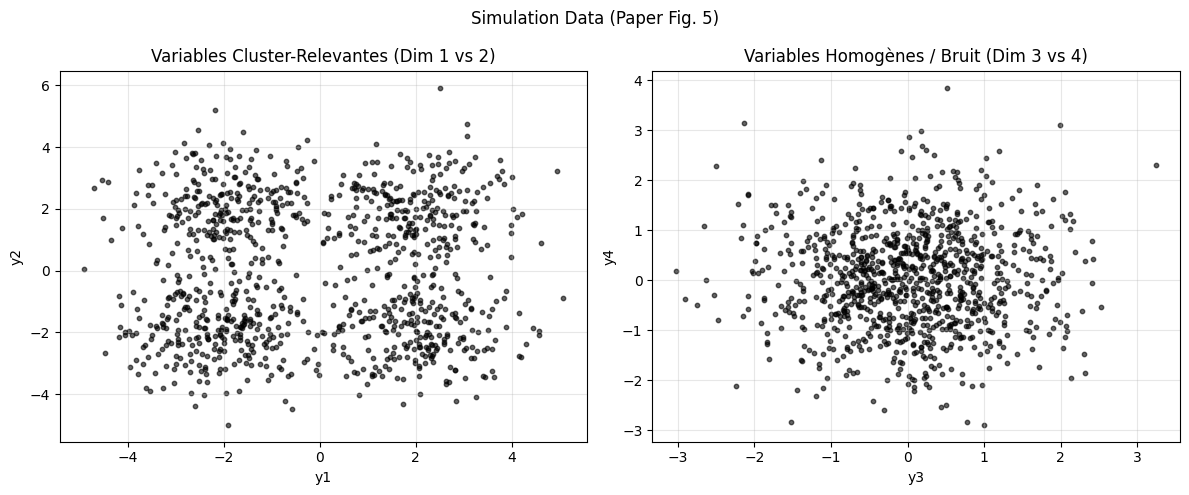

Lancement du MCMC...
Nombre de clusters estimé (Mode K0): 1
Relabeling réussi.
Estimation terminée. K final (mode des K0) : [0.00000000e+000 0.00000000e+000 0.00000000e+000 3.86125972e-027
 9.88131292e-324 1.46739359e-087 4.16870478e-029 1.00000000e+000
 6.00926507e-035 1.38015198e-050 0.00000000e+000 0.00000000e+000
 1.02344017e-051 0.00000000e+000 2.82289928e-263]
Vrais centres :
 [[ 2 -2  0  0]
 [-2  2  0  0]
 [ 2  2  0  0]
 [-2 -2  0  0]]


In [35]:
import numpy as np
import matplotlib.pyplot as plt

def generate_paper_data(n_samples=1000, scenario='equal', seed=42):
    """
    Génère les données synthétiques selon la Section 5.1 du papier.
    
    Args:
        n_samples (int): Nombre d'observations (1000 dans le papier)
        scenario (str): 'equal' ou 'unequal' pour les poids des clusters
        seed (int): Graine aléatoire pour reproductibilité
    
    Returns:
        y (np.ndarray): Les observations (N, 4)
        labels (np.ndarray): Les vrais labels (pour vérification)
    """
    np.random.seed(seed)
    
    # 1. Définition des paramètres (Sect 5.1)
    # Moyennes (Equation dans le texte, page 313)
    # mu1 = (2, -2, 0, 0), mu2 = -mu1, mu3 = (2, 2, 0, 0), mu4 = -mu3
    mu = np.array([
        [ 2, -2, 0, 0],
        [-2,  2, 0, 0],
        [ 2,  2, 0, 0],
        [-2, -2, 0, 0]
    ])
    
    # Covariances (Sigma_k = I_4)
    cov = np.eye(4)
    
    # Poids (Sect 5.1.1 et 5.1.2)
    if scenario == 'equal':
        weights = [0.25, 0.25, 0.25, 0.25]
    elif scenario == 'unequal':
        weights = [0.02, 0.33, 0.33, 0.32]
    else:
        raise ValueError("Scenario doit être 'equal' ou 'unequal'")
        
    # 2. Génération des effectifs par cluster
    n_per_cluster = np.random.multinomial(n_samples, weights)
    
    y_list = []
    labels_list = []
    
    # 3. Échantillonnage des Gaussiennes
    for k, n_k in enumerate(n_per_cluster):
        if n_k > 0:
            cluster_data = np.random.multivariate_normal(mu[k], cov, n_k)
            y_list.append(cluster_data)
            labels_list.append(np.full(n_k, k))
            
    y = np.vstack(y_list)
    labels = np.hstack(labels_list)
    
    # 4. Mélange des données (pour ne pas avoir les clusters ordonnés)
    perm = np.random.permutation(n_samples)
    y = y[perm]
    labels = labels[perm]
    
    return y, labels

def plot_paper_figure_5(y, title="Simulation Data (Paper Fig. 5)"):
    """
    Reproduit la visualisation de la Figure 5 du papier :
    - Scatter plot Dim 1 vs Dim 2 (Variables discriminantes)
    - Scatter plot Dim 3 vs Dim 4 (Variables de bruit)
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Dim 1 vs Dim 2
    axes[0].scatter(y[:, 0], y[:, 1], s=10, alpha=0.6, c='black')
    axes[0].set_title("Variables Cluster-Relevantes (Dim 1 vs 2)")
    axes[0].set_xlabel("y1")
    axes[0].set_ylabel("y2")
    axes[0].grid(True, alpha=0.3)
    
    # Dim 3 vs Dim 4
    axes[1].scatter(y[:, 2], y[:, 3], s=10, alpha=0.6, c='black')
    axes[1].set_title("Variables Homogènes / Bruit (Dim 3 vs 4)")
    axes[1].set_xlabel("y3")
    axes[1].set_ylabel("y4")
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# --- Exécution ---

# Génération
y_sim, true_labels = generate_paper_data(n_samples=1000, scenario='equal')

# Visualisation (Doit ressembler à la Fig 5)
plot_paper_figure_5(y_sim)

# Exemple d'utilisation avec ta classe MCMC
# K = 15 (Overfitting délibéré comme dans le papier, Table 1)
print("Lancement du MCMC...")
# Paramètres recommandés par le papier pour K=15 (Table 1 et discussion)
# e0 = 0.01 (très petit pour sparse prior)
# c0 et nu1/nu2 standards
model = SparseGaussianMixture(K=15, e0=0.001, c0=2.5 + (4-1)/2, nu1=0.5, nu2=0.5)
model.fit(y_sim, max_iter=10000, burn_in=1000)

print(f"Estimation terminée. K final (mode des K0) : {model.eta}")
print(f"Vrais centres :\n {np.array([[2,-2,0,0], [-2,2,0,0], [2,2,0,0], [-2,-2,0,0]])}")
# Note: l'ordre des centres estimés peut varier (permutation), c'est normal.